# Handling Timeseries Data in Pandas

* Topic: Data manipulation
* Unit: ADS1002
* Level: Beginner
* Authors: Simon Bowly
* Version: 3

Required files (download these from the Gitlab site [here](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Pandas-DataFrames/Time-Series) into the same directory as the notebook on your computer):

* [traffic-data.csv](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/tree/main/Pandas-DataFrames/Time-Series/traffic-data.csv)

The objective of this notebook is to give some background to time series data and to introduce you to the Pandas commands needed to manipulate time series. Most of the projects this semester involve working with some form of time series, and you will most likely need to filter, plot, and aggregate various parts of the data along the way. If your data fits this description, spend some time trying the commands introduced here with your dataset.

## Time Series Data

A time series is any dataset which varies over time. This usually means one or more measurements taken at some repeating interval. Some datasets you will work with will be measured at low frequencies, e.g. daily temperature forecasts, monthly sales numbers, and annual revenue, while others may be measured at high frequencies, for example hourly power usage, or millisecond frequency data from medical imaging equipment.

Pandas will handle time series data well if it is in the right format. It expects that rows in a dataframe are time-based observations, and columns are different measurements taken at the same time. As an example, each data `Series` (single column) should be structured like this:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a datetime index, with 6 hourly timestamps.
index = pd.date_range(start="2020-03-02", periods=6, freq='H')

# Some data (just some numbers increasing over time).
data = [1, 2, 3, 4, 5, 6]

# Construct a series using the index and data.
series = pd.Series(data, index=index)

# Show the index and the series.
print(index)
series

DatetimeIndex(['2020-03-02 00:00:00', '2020-03-02 01:00:00',
               '2020-03-02 02:00:00', '2020-03-02 03:00:00',
               '2020-03-02 04:00:00', '2020-03-02 05:00:00'],
              dtype='datetime64[ns]', freq='H')


2020-03-02 00:00:00    1
2020-03-02 01:00:00    2
2020-03-02 02:00:00    3
2020-03-02 03:00:00    4
2020-03-02 04:00:00    5
2020-03-02 05:00:00    6
Freq: H, dtype: int64

and a multi-column `DataFrame` should be structured like this:

In [3]:
# A datetime index, with 6 hourly timestamps.
index = pd.date_range(start="2020-03-02", periods=6, freq='H')

# Construct a dataframe (two columns) using the index and data.
dataframe = pd.DataFrame(
    data={
        "field1": [1, 2, 3, 4, 5, 6],
        "field2": ["a", "b", "c", "d", "e", "f"],
    },
    index=index,
)
dataframe

,field1,field2
2020-03-02 00:00:00,1,a
2020-03-02 01:00:00,2,b
2020-03-02 02:00:00,3,c
2020-03-02 03:00:00,4,d
2020-03-02 04:00:00,5,e
2020-03-02 05:00:00,6,f


Of course, you'll mostly be loading prepared datasets from another format, rather than constructing them this way, but it is useful to know how these datasets are assembled.

The examples below use road traffic data from several intersections around Melbourne. Values in the dataset represent the number of cars counted at a specific intersection in a given 15 minute period. We'll look at:

* converting types to ensure we have the correct time series layout;
* filtering subsets of the data;
* plotting the data against time; and
* grouping & aggregating data using time series functions.

## Loading Data

First, we load the dataset from csv. To use pandas to its fullest potential here, we need to ensure two things:

1. the ata is in a format where each row is a single time step, and each column is a different observation at that time; and
2. data types are set appropriately (in particular, the `datetime` data type is used to index the data).

**Please note** that it may take more work to get your particular dataset into this format, as some time series data is stored in a different layout. I haven't included specific examples here (since each case may be different) so ask the teaching staff how to approach your particular case.

In [4]:
raw_traffic_data = pd.read_csv("traffic-data.csv")
raw_traffic_data

,Timestamp,Site 100,Site 101,Site 102,Site 103,Site 105,Site 106,Site 107,Site 108,Site 109
0,2021-01-01 00:00:00,66.0,18.0,46.0,19.0,97.0,39.0,66.0,31.0,51.0
1,2021-01-01 00:15:00,124.0,83.0,88.0,57.0,231.0,79.0,207.0,112.0,109.0
2,2021-01-01 00:30:00,121.0,102.0,83.0,91.0,252.0,96.0,272.0,106.0,143.0
3,2021-01-01 00:45:00,130.0,115.0,112.0,59.0,279.0,89.0,278.0,87.0,126.0
4,2021-01-01 01:00:00,160.0,115.0,107.0,49.0,226.0,86.0,235.0,98.0,111.0
...,...,...,...,...,...,...,...,...,...,...
2971,2021-01-31 22:45:00,79.0,51.0,70.0,0.0,153.0,45.0,145.0,55.0,56.0
2972,2021-01-31 23:00:00,94.0,44.0,40.0,0.0,148.0,31.0,134.0,54.0,43.0
2973,2021-01-31 23:15:00,61.0,36.0,42.0,0.0,120.0,34.0,118.0,38.0,42.0
2974,2021-01-31 23:30:00,59.0,45.0,42.0,0.0,95.0,23.0,96.0,40.0,25.0


This dataset is already in the correct layout: each row corresponds to a single timestamp, and there are multiple measurements (columns). All that remains is to check the data types.

In [5]:
# Show data types for all columns in the dataframe.
raw_traffic_data.dtypes

Timestamp     object
Site 100     float64
Site 101     float64
Site 102     float64
Site 103     float64
Site 105     float64
Site 106     float64
Site 107     float64
Site 108     float64
Site 109     float64
dtype: object

We can see above that our count values are in `float` format, which is fine, but the 'Timestamp' column is in object format. Looking a little more closely we will see that these are actually stored as strings.

In [6]:
# Get the 'Timestamp' column from the first row.
single_timestamp = raw_traffic_data["Timestamp"].iloc[0]

# Print the value and it's type.
print("The first timestamp has value '{}' and data type {}".format(single_timestamp, type(single_timestamp)))

The first timestamp has value '2021-01-01 00:00:00' and data type <class 'str'>


This is a typical outcome when loading data from csv. In most cases, this will be easy enough to convert using `pd.to_datetime`. We also want the timestamps to be an index in the data, rather than a regular column. So we create a new dataframe as follows:

In [7]:
# For reference; this is the result of a datetime conversion.
# Note that the 'dtype' for this converted data is now 'datetime64'.
pd.to_datetime(raw_traffic_data["Timestamp"])

0      2021-01-01 00:00:00
1      2021-01-01 00:15:00
2      2021-01-01 00:30:00
3      2021-01-01 00:45:00
4      2021-01-01 01:00:00
               ...        
2971   2021-01-31 22:45:00
2972   2021-01-31 23:00:00
2973   2021-01-31 23:15:00
2974   2021-01-31 23:30:00
2975   2021-01-31 23:45:00
Name: Timestamp, Length: 2976, dtype: datetime64[ns]

In [8]:
# Create a new index from the timestamp column, with the proper type.
traffic_data = raw_traffic_data.set_index(pd.to_datetime(raw_traffic_data["Timestamp"]))

# Delete the column with our old string representation of times.
traffic_data = traffic_data.drop(columns=["Timestamp"])

# Show the index and the dataframe.
print(traffic_data.index)
traffic_data

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:15:00',
               '2021-01-01 00:30:00', '2021-01-01 00:45:00',
               '2021-01-01 01:00:00', '2021-01-01 01:15:00',
               '2021-01-01 01:30:00', '2021-01-01 01:45:00',
               '2021-01-01 02:00:00', '2021-01-01 02:15:00',
               ...
               '2021-01-31 21:30:00', '2021-01-31 21:45:00',
               '2021-01-31 22:00:00', '2021-01-31 22:15:00',
               '2021-01-31 22:30:00', '2021-01-31 22:45:00',
               '2021-01-31 23:00:00', '2021-01-31 23:15:00',
               '2021-01-31 23:30:00', '2021-01-31 23:45:00'],
              dtype='datetime64[ns]', name='Timestamp', length=2976, freq=None)


,Site 100,Site 101,Site 102,Site 103,Site 105,Site 106,Site 107,Site 108,Site 109
Timestamp,,,,,,,,,
2021-01-01 00:00:00,66.0,18.0,46.0,19.0,97.0,39.0,66.0,31.0,51.0
2021-01-01 00:15:00,124.0,83.0,88.0,57.0,231.0,79.0,207.0,112.0,109.0
2021-01-01 00:30:00,121.0,102.0,83.0,91.0,252.0,96.0,272.0,106.0,143.0
2021-01-01 00:45:00,130.0,115.0,112.0,59.0,279.0,89.0,278.0,87.0,126.0
2021-01-01 01:00:00,160.0,115.0,107.0,49.0,226.0,86.0,235.0,98.0,111.0
...,...,...,...,...,...,...,...,...,...
2021-01-31 22:45:00,79.0,51.0,70.0,0.0,153.0,45.0,145.0,55.0,56.0
2021-01-31 23:00:00,94.0,44.0,40.0,0.0,148.0,31.0,134.0,54.0,43.0
2021-01-31 23:15:00,61.0,36.0,42.0,0.0,120.0,34.0,118.0,38.0,42.0


Success! The data is now in native pandas time series format: the index is a `DatetimeIndex` and the remaining columns contain only our observed data, not the timestamp values.

## Selecting Data

Generally you will want to work with a subset of the data, particularly when it comes to visualisation. The following commands show how to select subsets of the data by specifying two dates as endpoints.

In [9]:
# Select a 2 hour period between two dates.
# The syntax is similar to other pandas commands - start and end of the interval,
# in square brackets, separated by a colon.
morning_data = traffic_data[pd.Timestamp("2021-01-04 06:00:00"):pd.Timestamp("2021-01-04 08:00:00")]
morning_data

,Site 100,Site 101,Site 102,Site 103,Site 105,Site 106,Site 107,Site 108,Site 109
Timestamp,,,,,,,,,
2021-01-04 06:00:00,70.0,84.0,141.0,64.0,224.0,87.0,241.0,72.0,82.0
2021-01-04 06:15:00,108.0,94.0,184.0,85.0,269.0,149.0,324.0,72.0,135.0
2021-01-04 06:30:00,157.0,114.0,198.0,107.0,331.0,152.0,378.0,109.0,180.0
2021-01-04 06:45:00,132.0,127.0,227.0,101.0,354.0,138.0,355.0,107.0,171.0
2021-01-04 07:00:00,143.0,142.0,256.0,110.0,355.0,142.0,415.0,123.0,181.0
2021-01-04 07:15:00,167.0,165.0,243.0,119.0,372.0,166.0,478.0,139.0,203.0
2021-01-04 07:30:00,217.0,156.0,298.0,127.0,512.0,188.0,484.0,158.0,239.0
2021-01-04 07:45:00,240.0,204.0,346.0,150.0,606.0,184.0,570.0,181.0,239.0
2021-01-04 08:00:00,192.0,174.0,322.0,143.0,479.0,176.0,603.0,190.0,239.0


An alternative way to write this is to use 'timedelta' to specify a start time and duration of the interval.

In [10]:
# Store a fixed start time in a variable.
start = pd.Timestamp("2021-01-04 06:00:00")
# Add an offset to use as the end time.note, you can use any time unit here; try e.g. days=2)
# and check the range of values returned.
traffic_data[start:start + pd.Timedelta(hours=1)]

,Site 100,Site 101,Site 102,Site 103,Site 105,Site 106,Site 107,Site 108,Site 109
Timestamp,,,,,,,,,
2021-01-04 06:00:00,70.0,84.0,141.0,64.0,224.0,87.0,241.0,72.0,82.0
2021-01-04 06:15:00,108.0,94.0,184.0,85.0,269.0,149.0,324.0,72.0,135.0
2021-01-04 06:30:00,157.0,114.0,198.0,107.0,331.0,152.0,378.0,109.0,180.0
2021-01-04 06:45:00,132.0,127.0,227.0,101.0,354.0,138.0,355.0,107.0,171.0
2021-01-04 07:00:00,143.0,142.0,256.0,110.0,355.0,142.0,415.0,123.0,181.0


Of course we can also select columns as normal, along with selecting a time range.

In [9]:
start = pd.Timestamp("2021-01-04 06:00:00")
end = start + pd.Timedelta(hours=1)

# Separate the row and column filters by a comma. Also note that
# we must use .loc[] syntax when specifying both rows and columns.
traffic_data.loc[start:end, ["Site 100", "Site 101"]]

,Site 100,Site 101
Timestamp,,
2021-01-04 06:00:00,70.0,84.0
2021-01-04 06:15:00,108.0,94.0
2021-01-04 06:30:00,157.0,114.0
2021-01-04 06:45:00,132.0,127.0
2021-01-04 07:00:00,143.0,142.0


# Plotting

Pandas has an in-built set of plotting methods (some of which you've seen before). While `seaborn` is most useful for plotting relationships between data, `pandas` own plotting commands are easier to work with when visualising time series. We'll use a subset of the data in these plots as plotting the entire dataset becomes very cluttered.

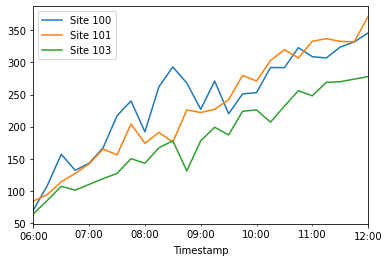

In [11]:
start = pd.Timestamp("2021-01-04 06:00:00")
end = start + pd.Timedelta(hours=6)
morning_data_three_sites = traffic_data.loc[start:end, ["Site 100", "Site 101", "Site 103"]]
# Plots each column as a different line, over the time range in the filtered dataframe.
morning_data_three_sites.plot.line();

In [12]:
morning_data_three_sites

,Site 100,Site 101,Site 103
Timestamp,,,
2021-01-04 06:00:00,70.0,84.0,64.0
2021-01-04 06:15:00,108.0,94.0,85.0
2021-01-04 06:30:00,157.0,114.0,107.0
2021-01-04 06:45:00,132.0,127.0,101.0
2021-01-04 07:00:00,143.0,142.0,110.0
2021-01-04 07:15:00,167.0,165.0,119.0
2021-01-04 07:30:00,217.0,156.0,127.0
2021-01-04 07:45:00,240.0,204.0,150.0
2021-01-04 08:00:00,192.0,174.0,143.0


Other types than the standard line plot can also be produced using the same style. An area plot gives a 'stacked' view of the data (each series is added on top of one another). This helps to show both the individual series' relative sizes as well as the total of all series at a given time.

Note you can use the `figsize` argument in any of these plot commands to expand the area of the plot in the notebook. The argument to figsize is a (width, height) tuple.

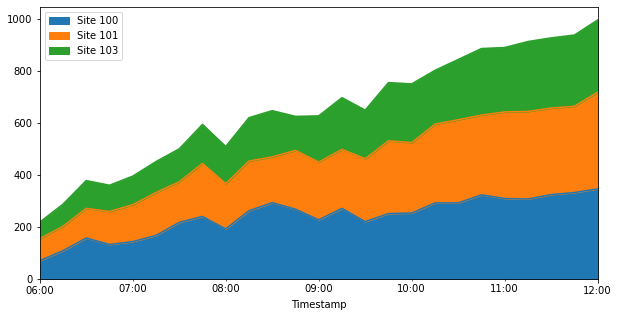

In [13]:
morning_data_three_sites.plot.area(figsize=(10, 5));

## Resampling

Resampling helps to aggregate data based on time. It is used when we have relatively high frequency data and need to 'downsample' to more useful statistics at a lower frequency. A useful result for this dataset might be to get daily traffic numbers by adding up all the 15 minute measurement windows.

Note that any of the usual statistics (e.g. min/max/mean/median...) can be used in place of `.sum()` here, to calculate different statistics.

In [14]:
three_sites = traffic_data[["Site 103", "Site 105", "Site 106"]]
three_sites
# Compute the sum of all 15 minute counts over each day.
# 1D = group by one day periods
daily = three_sites.resample("1D").sum()
daily.head()

,Site 103,Site 105,Site 106
Timestamp,,,
2021-01-01,10107.0,25724.0,11707.0
2021-01-02,12073.0,33606.0,14556.0
2021-01-03,11007.0,31182.0,12367.0
2021-01-04,12816.0,40829.0,15377.0
2021-01-05,13312.0,42254.0,16466.0


In [15]:
daily

,Site 103,Site 105,Site 106
Timestamp,,,
2021-01-01,10107.0,25724.0,11707.0
2021-01-02,12073.0,33606.0,14556.0
2021-01-03,11007.0,31182.0,12367.0
2021-01-04,12816.0,40829.0,15377.0
2021-01-05,13312.0,42254.0,16466.0
2021-01-06,14216.0,43697.0,18285.0
2021-01-07,14751.0,44356.0,18777.0
2021-01-08,15025.0,45793.0,19479.0
2021-01-09,13900.0,39118.0,17121.0


In [16]:
three_sites

,Site 103,Site 105,Site 106
Timestamp,,,
2021-01-01 00:00:00,19.0,97.0,39.0
2021-01-01 00:15:00,57.0,231.0,79.0
2021-01-01 00:30:00,91.0,252.0,96.0
2021-01-01 00:45:00,59.0,279.0,89.0
2021-01-01 01:00:00,49.0,226.0,86.0
...,...,...,...
2021-01-31 22:45:00,0.0,153.0,45.0
2021-01-31 23:00:00,0.0,148.0,31.0
2021-01-31 23:15:00,0.0,120.0,34.0


Note that the resulting dataframe now has an index with only daily entries, no specific times. Plotting the result as normal allows us to show a visual comparison of overall daily traffic at each site.

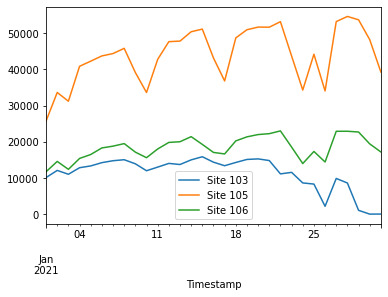

In [17]:
daily.plot.line();

## Rolling Mean

Rolling statistics (especially rolling averages) can be useful to smooth out time series data, correcting for minor fluctuations or measurement issues in order to observe general trends. They can also be used to compute "anomaly" measures, which compare observed values at a single time period to long- or short-term averages. A rolling mean takes a 'window' around each timestamp, of a given duration, and computes the average of all values in the window.

Computing rolling means is straightforward since our data is in the correct format. The code below plots the data against a rolling mean. Note that the 'centered' rolling mean is perhaps more informative here, since it will use 2 hours either side. The default rolling mean is computed based on 4 hours of data before the current time.

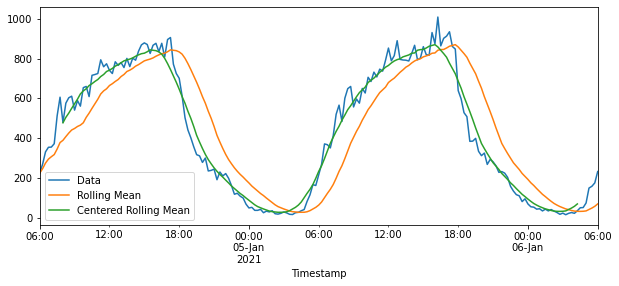

In [18]:
start = pd.Timestamp("2021-01-04 06:00:00")
end = start + pd.Timedelta(days=2)

# This gives us just a single series (for one site).
site_105 = traffic_data.loc[start:end, "Site 105"]

# Compute rolling means (4H = 4 hour rolling window).
rolling_mean = site_105.rolling('4H').mean()

# These two commands (the first is commented out since it only
# works in newer pandas versions) give a centered rolling mean. It
# is more convenient to use '4H' here, but 16 time periods (since
# the data is at 15 minute frequency is equivalent in this case.
# centered_rolling_mean = site_105.rolling('4H', center=True).mean()
centered_rolling_mean = site_105.rolling(16, center=True).mean()

# Plot each series. We can use the 'label' argument to label them
# individually since they are separate series.
site_105.plot.line(label='Data', figsize=(10, 4))
rolling_mean.plot.line(label='Rolling Mean')
centered_rolling_mean.plot.line(label='Centered Rolling Mean')

# Add a legend to show the labels.
plt.legend();

In [19]:
rolling_mean

Timestamp
2021-01-04 06:00:00    224.000000
2021-01-04 06:15:00    246.500000
2021-01-04 06:30:00    274.666667
2021-01-04 06:45:00    294.500000
2021-01-04 07:00:00    306.600000
                          ...    
2021-01-06 05:00:00     34.125000
2021-01-06 05:15:00     41.312500
2021-01-06 05:30:00     48.500000
2021-01-06 05:45:00     57.312500
2021-01-06 06:00:00     69.250000
Name: Site 105, Length: 193, dtype: float64

In [20]:
centered_rolling_mean = site_105.rolling(16, center=True).mean()
centered_rolling_mean

Timestamp
2021-01-04 06:00:00   NaN
2021-01-04 06:15:00   NaN
2021-01-04 06:30:00   NaN
2021-01-04 06:45:00   NaN
2021-01-04 07:00:00   NaN
                       ..
2021-01-06 05:00:00   NaN
2021-01-06 05:15:00   NaN
2021-01-06 05:30:00   NaN
2021-01-06 05:45:00   NaN
2021-01-06 06:00:00   NaN
Name: Site 105, Length: 193, dtype: float64

## Time-based Aggregation and Pivoting

For time series data over a long period, we may want to compare the same time of day across multiple days. To do this, we can first use the timestamped index to add some labelling columns:

* The date (without time)
* The time of day (without date)
* The day of the week

A similar approach to this could be used to, for example, compare the same month, year to year.

In [21]:
# Creates three new columns, which specify the date (without time), time of day (without the date)
# and the day of the week as a categorical value.
traffic_data = traffic_data.assign(
    Date=lambda df: df.index.floor("D"),
    TimeOfDay=lambda df: df.index - df.Date,
    DayOfWeek=lambda df: df.index.day_name().astype("category"),
)
# Just show a few rows with these additional columns.
traffic_data.head()

,Site 100,Site 101,Site 102,Site 103,Site 105,Site 106,Site 107,Site 108,Site 109,Date,TimeOfDay,DayOfWeek
Timestamp,,,,,,,,,,,,
2021-01-01 00:00:00,66.0,18.0,46.0,19.0,97.0,39.0,66.0,31.0,51.0,2021-01-01,0 days 00:00:00,Friday
2021-01-01 00:15:00,124.0,83.0,88.0,57.0,231.0,79.0,207.0,112.0,109.0,2021-01-01,0 days 00:15:00,Friday
2021-01-01 00:30:00,121.0,102.0,83.0,91.0,252.0,96.0,272.0,106.0,143.0,2021-01-01,0 days 00:30:00,Friday
2021-01-01 00:45:00,130.0,115.0,112.0,59.0,279.0,89.0,278.0,87.0,126.0,2021-01-01,0 days 00:45:00,Friday
2021-01-01 01:00:00,160.0,115.0,107.0,49.0,226.0,86.0,235.0,98.0,111.0,2021-01-01,0 days 01:00:00,Friday


These labels can be used to aggregate and summarise data. The `groupby` operation here collects data according to the values of some selected columns and calculates summary statistics on each group. The result is a summary row for each group.

The grouping here uses day of the week and time of day, and we are asking for the median statistic. Hence each value in the resulting dataframe represents (for example) "the median number of cars seen at Site 101 at 12:30am on a Friday". This value is an aggregation of all Friday data at that time of day.

In [22]:
aggregated = traffic_data.groupby(["DayOfWeek", "TimeOfDay"]).median()
aggregated

Site 100  Site 101  Site 102  Site 103  Site 105  \
DayOfWeek TimeOfDay                                                           
Friday    0 days 00:00:00      60.0      28.0      33.0      22.0      76.0   
          0 days 00:15:00      58.0      26.0      36.0      23.0      60.0   
          0 days 00:30:00      38.0      19.0      23.0      20.0      54.0   
          0 days 00:45:00      46.0      18.0      22.0      13.0      49.0   
          0 days 01:00:00      28.0      32.0      20.0       8.0      46.0   
...                             ...       ...       ...       ...       ...   
Wednesday 0 days 22:45:00     114.5      54.0      79.0      38.0     151.5   
          0 days 23:00:00     105.0      63.5      59.0      37.5     159.0   
          0 days 23:15:00      92.0      43.5      49.0      31.5     128.0   
          0 days 23:30:00      70.5      38.5      42.5      29.0     111.0   
          0 days 23:45:00      58.5      38.0      30.5      13.5      95.5   

                           Site 106  Site 107  Site 108  Site 109  
DayOfWeek TimeOfDay                                                
Friday    0 days 00:00:00      23.0      68.0      29.0      26.0  
          0 days 00:15:00      26.0      58.0      25.0      28.0  
          0 days 00:30:00      23.0      46.0      24.0      25.0  
          0 days 00:45:00      17.0      43.0      20.0      15.0  
          0 days 01:00:00      12.0      37.0      16.0      16.0  
...                             ...       ...       ...       ...  
Wednesday 0 days 22:45:00      48.5     176.5      56.5      62.0  
          0 days 23:00:00      39.0     139.5      57.5      51.5  
          0 days 23:15:00      36.5     129.5      50.5      44.0  
          0 days 23:30:00      34.0      96.5      37.0      40.0  
          0 days 23:45:00      27.0      79.5      33.0      32.5  

[672 rows x 9 columns]

The `unstack` and `stack` functions move labels from the index to columns (and vice-versa). In this case `unstack` expands the day of the week to produce multiple column levels. This is a useful way to rearrange the data into the form of a different time series: where the index represents the time of day, and a column represents our median traffic results at a given site for a given day of the week.

In [23]:
# Unstack the first part of the index (day of week).
pivoted = aggregated.unstack(0)
pivoted.head()

Site 100                                                    \
DayOfWeek         Friday Monday Saturday Sunday Thursday Tuesday Wednesday   
TimeOfDay                                                                    
0 days 00:00:00     60.0   54.5     79.0   91.0     51.5    52.0      49.0   
0 days 00:15:00     58.0   40.5     65.0   84.0     42.5    50.5      43.5   
0 days 00:30:00     38.0   37.5     60.0   77.0     38.5    35.0      35.5   
0 days 00:45:00     46.0   32.5     52.0   63.0     34.5    31.5      33.5   
0 days 01:00:00     28.0   23.5     47.0   54.0     30.0    29.5      27.5   

                Site 101                  ... Site 108                    \
DayOfWeek         Friday Monday Saturday  ... Thursday Tuesday Wednesday   
TimeOfDay                                 ...                              
0 days 00:00:00     28.0   26.5     40.0  ...     22.0    24.0      23.5   
0 days 00:15:00     26.0   20.5     41.0  ...     25.0    23.5      23.0   
0 days 00:30:00     19.0   16.0     28.0  ...     15.0    24.0      14.0   
0 days 00:45:00     18.0   21.5     28.0  ...     16.5    13.5      14.5   
0 days 01:00:00     32.0   17.0     35.0  ...      9.0    11.0       8.5   

                Site 109                                                    
DayOfWeek         Friday Monday Saturday Sunday Thursday Tuesday Wednesday  
TimeOfDay                                                                   
0 days 00:00:00     26.0   29.0     42.0   60.0     29.5    26.5      26.0  
0 days 00:15:00     28.0   21.5     40.0   65.0     23.0    18.0      18.0  
0 days 00:30:00     25.0   12.5     44.0   48.0     19.0    16.0      17.0  
0 days 00:45:00     15.0   13.0     31.0   45.0     10.0    20.5      15.5  
0 days 01:00:00     16.0   14.0     27.0   36.0     13.5    17.0       9.5  

[5 rows x 63 columns]

Selecting a column in this 'pivoted' result now just refers to the first level of columns (the traffic site). As a result this selection picks one site and returns a column for each day, with rows representing the time of day.

In [24]:
site_100 = pivoted["Site 100"]
site_100

DayOfWeek,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
TimeOfDay,,,,,,,
0 days 00:00:00,60.0,54.5,79.0,91.0,51.5,52.0,49.0
0 days 00:15:00,58.0,40.5,65.0,84.0,42.5,50.5,43.5
0 days 00:30:00,38.0,37.5,60.0,77.0,38.5,35.0,35.5
0 days 00:45:00,46.0,32.5,52.0,63.0,34.5,31.5,33.5
0 days 01:00:00,28.0,23.5,47.0,54.0,30.0,29.5,27.5
...,...,...,...,...,...,...,...
0 days 22:45:00,138.0,96.5,143.0,101.0,120.0,113.0,114.5
0 days 23:00:00,109.0,98.5,130.0,93.0,102.5,101.0,105.0
0 days 23:15:00,128.0,87.0,119.0,83.0,90.0,69.0,92.0


The result is median hourly counts of cars, at Site 100, aggregated for each day of the week over the 1 month of data in the dataset. Let's plot it for comparison. The resulting plot helps us to 

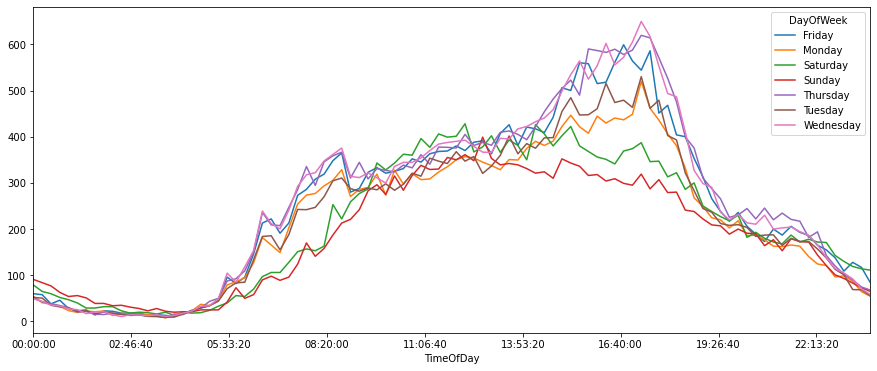

In [25]:
site_100.plot.line(figsize=(15, 6));

## Exercises

Complete the following exercises before the studio in week 4, and submit your result through moodle. Ensure that you answer each of the follow up questions after you complete the code for each exercise (add your answer to the markdown cell for the exercise in each case).

### Exercise 1  (Filtering)

Q: Plot only the data (from the full day) for 18th January 2021 for Site 107 as a line plot. What is the busiest period of the day?  Are there any issues with this data?

A:

In [26]:
jan18data = traffic_data[pd.Timestamp("2021-01-18 00:00:00"):pd.Timestamp("2021-01-18 23:45:00")]
start = pd.Timestamp("2021-01-18 00:00:00")
end = start + pd.Timedelta(hours=24)
jan18data.loc[start:end, ["Site 107"]]


,Site 107
Timestamp,
2021-01-18 00:00:00,64.0
2021-01-18 00:15:00,54.0
2021-01-18 00:30:00,46.0
2021-01-18 00:45:00,43.0
2021-01-18 01:00:00,22.0
...,...
2021-01-18 22:45:00,137.0
2021-01-18 23:00:00,109.0
2021-01-18 23:15:00,95.0


<AxesSubplot:xlabel='Timestamp'>

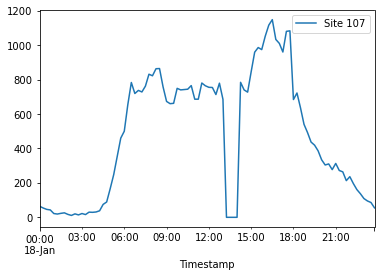

In [27]:
jan18data.loc[start:end, ["Site 107"]].plot.line()

In [ ]:
#On 18th of Jan,2021,the busiest hout was at 18:00.
#The issue is the traffic at around 14;00 was even lower than midnight of the day.
#which is not realistic.

### Exercise 2 (Resampling)

Q: Calculate and plot the number of cars seen in the busiest 15 minute period each day for Site 103 (i.e. the maximum of all 15 minute periods across each day). What do you observe?

A:

In [28]:
site = traffic_data[["Site 103"]]
three_sites
# Compute the sum of all 15 minute counts over each day.
# 1D = group by one day periods
daily103 = site.resample("1D").max()
daily.head()

,Site 103,Site 105,Site 106
Timestamp,,,
2021-01-01,10107.0,25724.0,11707.0
2021-01-02,12073.0,33606.0,14556.0
2021-01-03,11007.0,31182.0,12367.0
2021-01-04,12816.0,40829.0,15377.0
2021-01-05,13312.0,42254.0,16466.0


AxesSubplot(0.125,0.125;0.775x0.755)


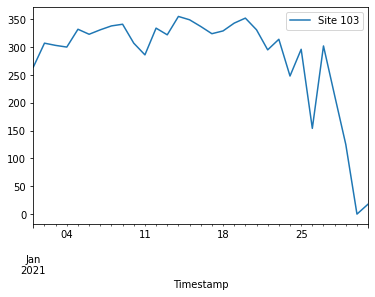

In [29]:
print(daily103.plot.line())





In [ ]:
#From the graph we can see the the degree of traffic is greatly decrease on 26th of Jan, then the next day bounces back.
#During the weekend, the traffic went down again .

### Exercise 3 (Rolling)

Q: Plot the 2-hourly rolling mean, over the first week of January for Site 109. What is the busiest day in this period?

A:

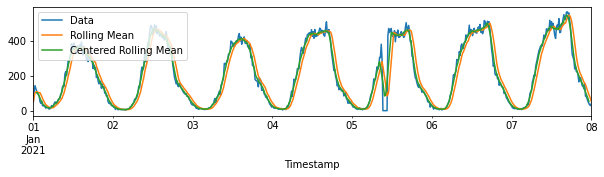

In [31]:
start = pd.Timestamp("2021-01-01 00:00:00")
end = start + pd.Timedelta(days=7)

# This gives us just a single series (for one site).
site_109 = traffic_data.loc[start:end, "Site 109"]

# Compute rolling means (2H = 2 hour rolling window).
rolling_mean = site_109.rolling('2H').mean()

# These two commands (the first is commented out since it only
# works in newer pandas versions) give a centered rolling mean. It
# is more convenient to use '2H' here, but 8 time periods (since
# the data is at 15 minute frequency is equivalent in this case.
# centered_rolling_mean = site_109.rolling('2H', center=True).mean()
centered_rolling_mean = site_109.rolling(8, center=True).mean()

# Plot each series. We can use the 'label' argument to label them
# individually since they are separate series.
site_109.plot.line(label='Data', figsize=(10, 2))
rolling_mean.plot.line(label='Rolling Mean')
centered_rolling_mean.plot.line(label='Centered Rolling Mean')

# Add a legend to show the labels.
plt.legend();

In [ ]:
#From the graph we can tell 7th of Jan was the busiest day.

### Exercise 4 (Pivot/aggregate)

Q: Plot the maximum traffic seen in each 15 minute window of the day on any Monday in the dataset for any two sites. What is the busiest time of day on a Monday at the sites you have chosen?

A:

In [32]:
# Hint: this dataframe already contains TimeOfDay and DayOfWeek which you can use for
# group and pivot operations.
traffic_data

,Site 100,Site 101,Site 102,Site 103,Site 105,Site 106,Site 107,Site 108,Site 109,Date,TimeOfDay,DayOfWeek
Timestamp,,,,,,,,,,,,
2021-01-01 00:00:00,66.0,18.0,46.0,19.0,97.0,39.0,66.0,31.0,51.0,2021-01-01,0 days 00:00:00,Friday
2021-01-01 00:15:00,124.0,83.0,88.0,57.0,231.0,79.0,207.0,112.0,109.0,2021-01-01,0 days 00:15:00,Friday
2021-01-01 00:30:00,121.0,102.0,83.0,91.0,252.0,96.0,272.0,106.0,143.0,2021-01-01,0 days 00:30:00,Friday
2021-01-01 00:45:00,130.0,115.0,112.0,59.0,279.0,89.0,278.0,87.0,126.0,2021-01-01,0 days 00:45:00,Friday
2021-01-01 01:00:00,160.0,115.0,107.0,49.0,226.0,86.0,235.0,98.0,111.0,2021-01-01,0 days 01:00:00,Friday
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-31 22:45:00,79.0,51.0,70.0,0.0,153.0,45.0,145.0,55.0,56.0,2021-01-31,0 days 22:45:00,Sunday
2021-01-31 23:00:00,94.0,44.0,40.0,0.0,148.0,31.0,134.0,54.0,43.0,2021-01-31,0 days 23:00:00,Sunday
2021-01-31 23:15:00,61.0,36.0,42.0,0.0,120.0,34.0,118.0,38.0,42.0,2021-01-31,0 days 23:15:00,Sunday


In [55]:
aggregated=traffic_data.groupby(['DayOfWeek','TimeOfDay']).max()

In [56]:
pivoted_M= aggregated.unstack(0)

In [66]:
site_100=pivoted_M["Site 100"]

In [67]:
site_100=site_100['Monday']

In [68]:
site_100

TimeOfDay
0 days 00:00:00     63.0
0 days 00:15:00     56.0
0 days 00:30:00     40.0
0 days 00:45:00     45.0
0 days 01:00:00     31.0
                   ...  
0 days 22:45:00    104.0
0 days 23:00:00    116.0
0 days 23:15:00    115.0
0 days 23:30:00     87.0
0 days 23:45:00     74.0
Name: Monday, Length: 96, dtype: float64

In [69]:
site_101=pivoted_M["Site 101"]['Monday']

In [70]:
site_101

TimeOfDay
0 days 00:00:00    40.0
0 days 00:15:00    25.0
0 days 00:30:00    26.0
0 days 00:45:00    27.0
0 days 01:00:00    22.0
                   ... 
0 days 22:45:00    85.0
0 days 23:00:00    76.0
0 days 23:15:00    55.0
0 days 23:30:00    34.0
0 days 23:45:00    36.0
Name: Monday, Length: 96, dtype: float64

<AxesSubplot:xlabel='TimeOfDay'>

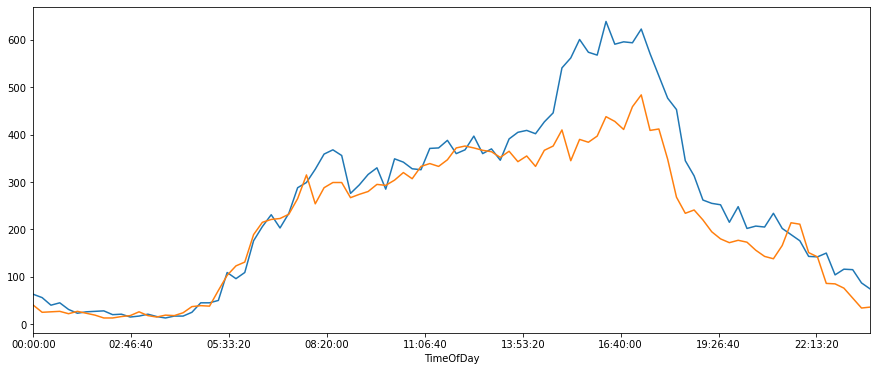

In [72]:
site_100.plot.line(label='100',figsize=(15,6))
site_101.plot.line(label='101',figsize=(15,6))

In [ ]:
#In both site of 101 and 100, the busiest hour for one of the Mondays were at 16:40.